# Selcting the Best Module

The objectives of this notebooks are:

- Understand the Concept of overfitting and underfitting
- Understand the concept of generalization
- understand the cross-validation framework used to evaluate a model


## Overfitting vs Underfitting

Overfitting occurs when
- The fitted model performs better on training data than on test (new) data (does not generalize well)
- Model's flexibility captures too much noise in the data
- Not enough training data to fit model


Underfitting occurs when:
- Model is too simple for data
- Model does not perform well on the training data
- Model captures little noise
- There is normally enough datta




# Cross-validation Framework

In [1]:
from sklearn.datasets import fetch_california_housing

housing_dict = fetch_california_housing(as_frame=True)

# Extracting the features
features_df = housing_dict['data']


# Extracting the Target
target = housing_dict['target']

In [2]:
housing_dict['DESCR']

'.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 20640\n\n    :Number of Attributes: 8 numeric, predictive attributes and the target\n\n    :Attribute Information:\n        - MedInc        median income in block group\n        - HouseAge      median house age in block group\n        - AveRooms      average number of rooms per household\n        - AveBedrms     average number of bedrooms per household\n        - Population    block group population\n        - AveOccup      average number of household members\n        - Latitude      block group latitude\n        - Longitude     block group longitude\n\n    :Missing Attribute Values: None\n\nThis dataset was obtained from the StatLib repository.\nhttps://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html\n\nThe target variable is the median house value for California districts,\nexpressed in hundreds of thousands of dollars ($100,000

In [3]:
features_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
# Multiplying the Prices by 1000's to transform to the 1000s range
target *= 1000

In [5]:
target

0        4526.0
1        3585.0
2        3521.0
3        3413.0
4        3422.0
          ...  
20635     781.0
20636     771.0
20637     923.0
20638     847.0
20639     894.0
Name: MedHouseVal, Length: 20640, dtype: float64

> This is a regression problem.

## Training vs Testing Error

In [6]:
# Using a Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# initialize the regressor
regressor = DecisionTreeRegressor(random_state=0)

# Fit the Regressor to  the data
regressor.fit(features_df, target)

DecisionTreeRegressor(random_state=0)

After training the regressor, we would like to know its potential generalization performance once deployed in production. For this purpose, we use the mean absolute error, which gives us an error in the native unit, i.e. k$.

In [7]:
from sklearn.metrics import mean_absolute_error


# The Target Prediction
target_pred = regressor.predict(features_df)

# score
score = mean_absolute_error(target, target_pred)

print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


> The error reported above is the training error

Thus properly evaluating our model involves:

* splitting our dataset into two subsets: a training set and a testing set;
* fitting the model on the training set;
* estimating the training error on the training set;
* estimating the testing error on the testing set.

So let's split our dataset.

In [8]:
from sklearn.model_selection import train_test_split

feature_train_df, feature_test_df, target_train, target_test = train_test_split(
                                                                        features_df,
                                                                        target,
                                                                        random_state=123
                                                                                )

# Fit data to the training set
regressor.fit(feature_train_df, target_train)


# Perform prediction with the trained model on the test set
target_pred = regressor.predict(feature_test_df)


# score
score = mean_absolute_error(target_test, target_pred)

print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 462.65 k$


## Stability of the cross-validation estimates

When doing a single train-test split we don't give any indication regarding
the robustness of the evaluation of our predictive model: in particular, if
the test set is small, this estimate of the testing error will be unstable and
wouldn't reflect the "true error rate" we would have observed with the same
model on an unlimited amount of test data.

For instance, we could have been lucky when we did our random split of our
limited dataset and isolated some of the easiest cases to predict in the
testing set just by chance: the estimation of the testing error would be
overly optimistic, in this case.

**Cross-validation** allows estimating the robustness of a predictive model by
repeating the splitting procedure. It will give several training and testing
errors and thus some **estimate of the variability of the model generalization
performance**.

There are [different cross-validationstrategies](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators),
this notebook focuses on one called "shuffle-split". At each iteration
of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational
cost increases with `n_splits`.

In [9]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

# Set the CV mode
cv_mode = ShuffleSplit(n_splits=40, test_size=30, random_state=123)

# Perform cross validation
cv_results = cross_validate(
                    # Your model
                    regressor,
                    # Your features
                    features_df,
                    # Your Target
                    target,
                    # Your model of cross validation
                    cv=cv_mode,
                    # Scoring metric
                    scoring='neg_mean_absolute_error'
                          )

# Cast CV results to a DF
cv_results = pd.DataFrame(cv_results)

# View the rsults
cv_results.head()

,fit_time,score_time,test_score
0,0.754086,0.003226,-603.201000
1,0.638098,0.003051,-492.133333
2,0.605115,0.000000,-424.400000
3,0.741863,0.007026,-561.034000
4,0.612680,0.002004,-625.767667


> A `score` is a metric for which `higher values mean better results`. On the contrary, an `error` is a metric for which `lower values mean better results`. The parameter scoring in cross_validate always expect a function that is a score.

> To make it easy, all error metrics in scikit-learn, like mean_absolute_error, can be transformed into a score to be used in cross_validate. To do so, you need to pass a string of the error metric with an additional neg_ string at the front to the parameter scoring; for instance scoring="neg_mean_absolute_error". In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.

In [10]:
cv_results['test_error'] = -cv_results['test_score']


cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.754086,0.003226,-603.201000,603.201000
1,0.638098,0.003051,-492.133333,492.133333
2,0.605115,0.000000,-424.400000,424.400000
3,0.741863,0.007026,-561.034000,561.034000
4,0.612680,0.002004,-625.767667,625.767667


In [11]:
cv_results.shape

(40, 4)

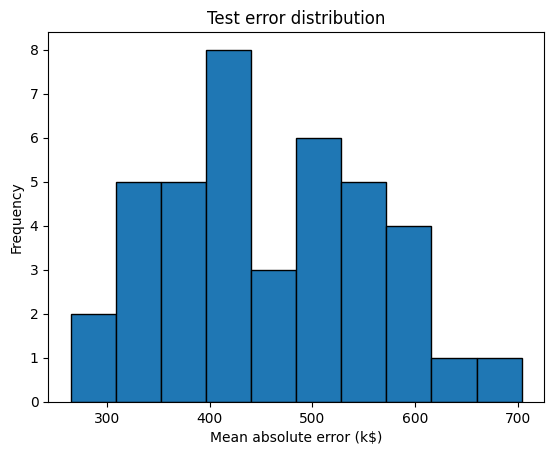

In [12]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [13]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)

The mean cross-validated testing error is: 459.26 k$


In [14]:
print(
    "The standard deviation of the cross-validated testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)

The standard deviation of the cross-validated testing error is: 103.31 k$


Note that the standard deviation is much smaller than the mean: we could summarize that our cross-validation estimate of the testing error is 459.26 ± 103.31 k$.

If we were to train a single model on the full dataset (without cross-validation) and then later had access to an unlimited amount of test data, we would expect its true testing error to fall close to that region.

While this information is interesting in itself, it should be contrasted to the scale of the natural variability of the vector target in our dataset.

Let us plot the distribution of the target variable:

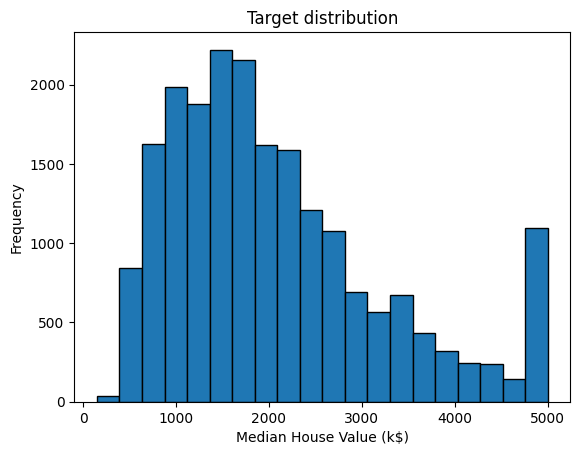

In [15]:
target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [16]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 1153.96 k$


The target variable ranges from close to 0 k\\$ up to 5000 k\\$ and, with a
standard deviation around 113.965 k\\$.

We notice that the mean estimate of the testing error obtained by
cross-validation is a bit smaller than the natural scale of variation of the
target variable. Furthermore, the standard deviation of the cross validation
estimate of the testing error is even smaller.

This is a good start, but not necessarily enough to decide whether the
generalization performance is good enough to make our prediction useful in
practice.

We recall that our model makes, on average, an er60or around 47 k\\$. With this
information and looking at the target distribution, such an error might be
acceptable when predicting hou0ses with a 500 k\\$. However, it would be an
issue with a house wit0h a value of 50 k\\$. Thus, this indicates that our
metric (Mean Absolute Error) is not ideal.

We might instead choose a metric relative to the target value to predict: the
mean absolute percentage error would have been a much better choice.

But in al460cases, an error of 47 k\\$ might be too large to automatically use
our model to tag house values without expert supervision.

## More detail regarding `cross_validate`

During cross-validation, many models are trained and evaluated. Indeed, the
number of elements in each array of the output of `cross_validate` is a result
from one of these `fit`/`score` procedures. To make it explicit, it is
possible to retrieve these fitted models for each of the splits/folds by
passing the option `return_estimator=True` in `cross_validate`.

In [17]:
cv_results = cross_validate(regressor, features_df, target, return_estimator=True)
cv_results

{'fit_time': array([0.58312964, 0.56607533, 0.5149703 , 0.55165339, 0.57281709]),
 'score_time': array([0.00655174, 0.        , 0.        , 0.00254035, 0.        ]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.27573937, 0.41037287, 0.41409936, 0.22466003, 0.45662602])}

In the case where you only are interested in the test score, scikit-learn
provide a `cross_val_score` function. It is identical to calling the
`cross_validate` function and to select the `test_score` only (as we
extensively did in the previous notebooks).

In [18]:
from sklearn.model_selection import cross_val_score

# Returning the scores without the intermediate cv_results step
scores = cross_val_score(regressor, features_df, target, cv=cv_mode, scoring='neg_mean_absolute_error')

scores

array([-603.201     , -492.13333333, -424.4       , -561.034     ,
       -625.76766667, -451.50066667, -429.96733333, -407.6       ,
       -599.20066667, -432.23433333, -591.80066667, -399.70033333,
       -554.46766667, -366.93366667, -264.36666667, -703.86833333,
       -519.567     , -458.83366667, -341.        , -489.10066667,
       -382.90033333, -360.00066667, -388.76666667, -599.30066667,
       -566.568     , -346.06666667, -532.33366667, -430.267     ,
       -552.60066667, -284.43366667, -453.90066667, -499.40066667,
       -523.56666667, -317.33366667, -434.701     , -344.501     ,
       -384.467     , -514.50033333, -396.80066667, -341.23366667])

In [19]:
scores.mean()

-459.2580250000001

In [20]:
scores.std()

102.01077519162665

## Overfitting - Generalization - Underfit




In [21]:
# Overfitting vs Under-fitting
cv_mode = ShuffleSplit(n_splits=30, test_size=0.2, random_state=123)

cv_results = cross_validate(
                    regressor,
                    features_df,
                    target,
                    cv=cv_mode,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    n_jobs=2
                          )

# Vonvert CV to DF
cv_results = pd.DataFrame(cv_results)


# Preview the results
cv_results.head()

,fit_time,score_time,test_score,train_score
0,0.335535,0.004007,-457.218692,-6.725370e-14
1,0.341536,0.003126,-477.780703,-6.885104e-14
2,0.374337,0.000000,-473.984656,-6.372852e-14
3,0.367310,0.000000,-455.596873,-7.006282e-14
4,0.377969,0.000000,-484.557803,-6.901628e-14


In [22]:
# Convert from score to error
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
                                                        ["train_score", "test_score"]
                                                   ]

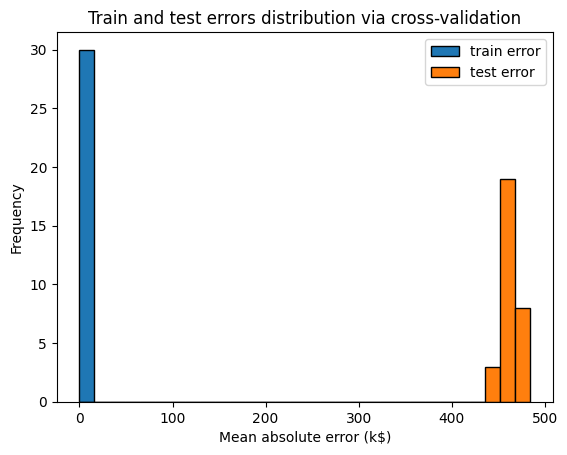

In [23]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=30, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Here, we observe a **small training error** (actually zero), meaning that the
model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the model is
**over-fitting**: the model has memorized many variations of the training set
that could be considered "noisy" because they do not generalize to help us
make good prediction on the test set.

## Validation curve

We call **hyperparameters** those parameters that potentially impact the
result of the learning and subsequent predictions of a predictor. For example:

- the number of neighbors in a k-nearest neighbor model;

- the degree of the polynomial.

Some model hyperparameters are usually the key to go from a model that
underfits to a model that overfits, hopefully going through a region were we
can get a good balance between the two. We can acquire knowledge by plotting a
curve called the validation curve. This curve can also be applied to the above
experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` hyperparameter is used to control the
tradeoff between under-fitting and over-fitting.

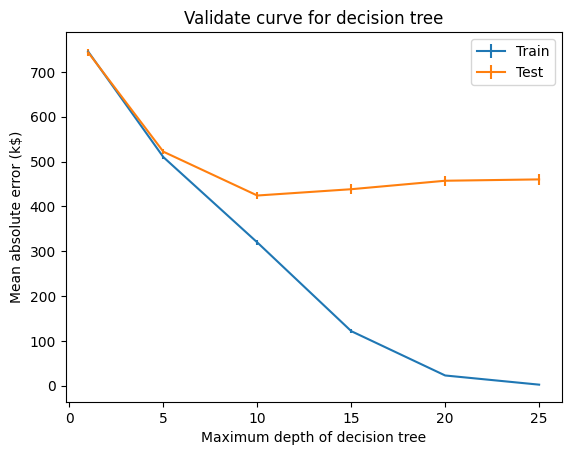

In [24]:
from sklearn.model_selection import ValidationCurveDisplay
import numpy as np

max_depth = np.array([1, 5, 10, 15, 20, 25])


disp = ValidationCurveDisplay.from_estimator(
                regressor,
                features_df,
                target,
                param_name='max_depth',
                param_range=max_depth,
                cv=cv_mode,
                scoring='neg_mean_absolute_error',
                negate_score=True,
                std_display_style='errorbar',
                n_jobs=2
                            )

_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)

The validation curve can be divided into three areas:

- For `max_depth < 10`, the decision tree underfits. The training error and
  therefore the testing error are both high. The model is too constrained and
  cannot capture much of the variability of the target variable.

- The region around `max_depth = 10` corresponds to the parameter for which
  the decision tree generalizes the best. It is flexible enough to capture a
  fraction of the variability of the target that generalizes, while not
  memorizing all of the noise in the target.

- For `max_depth > 10`, the decision tree overfits. The training error becomes
  very small, while the testing error increases. In this region, the models
  create decisions specifically for noisy samples harming its ability to
  generalize to test data.

Note that for `max_depth = 10`, the model overfits a bit as there is a gap
between the training error and the testing error. It can also potentially
underfit also a bit at the same time, because the training error is still far
from zero (more than 30 k\\$), meaning that the model might still be too
constrained to model interesting parts of the data. However, the testing error
is minimal, and this is what really matters. This is the best compromise we
could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also
look at the standard deviation to assess the dispersion of the score. For such
purpose, we can use the parameter `std_display_style` to show the standard
deviation of the errors as well. In this case, the variance of the errors is
small compared to their respective values, and therefore the conclusions above
are quite clear. This is not necessarily always the case.

## Effect of Sample Size on Cross Validation

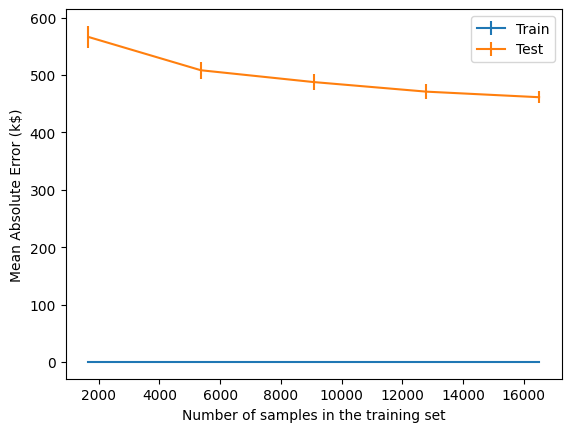

In [27]:
from sklearn.model_selection import LearningCurveDisplay

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

disp = LearningCurveDisplay.from_estimator(
                regressor,
                features_df,
                target,
                train_sizes=train_sizes, 
                cv=cv_mode,
                score_type='both', #Training and testing
                scoring='neg_mean_absolute_error',
                negate_score=True,
                score_name='Mean Absolute Error (k$)', 
                std_display_style='errorbar',
                n_jobs=2
                            )



Looking at the training error alone, we see that we get an error of 0 k$. It
means that the trained model (i.e. decision tree) is clearly overfitting the
training data.

Looking at the testing error alone, we observe that the more samples are
added into the training set, the lower the testing error becomes. Also, we
are searching for the plateau of the testing error for which there is no
benefit to adding samples anymore or assessing the potential gain of adding
more samples into the training set.

> If we achieve a plateau and adding new samples in the training set does not
reduce the testing error, we might have reached the Bayes error rate using the
available model. Using a more complex model might be the only possibility to
reduce the testing error further.

In [29]:
import pandas as pd

# Get the df_url
df_url = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/main/datasets/blood_transfusion.csv'

# Grab the df
blood_tr_df = pd.read_csv(df_url)

# Preview the data
blood_tr_df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


In [30]:
# target
target = blood_tr_df['Class']

# Features DF
features_df = blood_tr_df.drop(columns='Class')

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


# Write Your Transformers
num_transformer = Pipeline(
                        # Standardize the numerical features
                       steps=('num_std', StandardScaler())
                         )



pre_proc = ColumnTransformer(
                                [
                    # Standardize the numerical features
                    ('num', num_transformer, features_df.columns)
                                ]
                            )

# Initialize the classifier
sv_class = SVC(kernel='rbf')



# Overfitting vs Under-fitting
cv_mode = ShuffleSplit(n_splits=30, test_size=0.2, random_state=123)

cv_results = cross_validate(
                    sv_class,
                    features_df,
                    target,
                    cv=cv_mode,
                          )

# Vonvert CV to DF
cv_results = pd.DataFrame(cv_results)


# Preview the results
cv_results.head()

,fit_time,score_time,test_score
0,0.022409,0.001405,0.740000
1,0.019869,0.009253,0.786667
2,0.023503,0.009414,0.733333
3,0.021643,0.009002,0.740000
4,0.024355,0.012735,0.753333


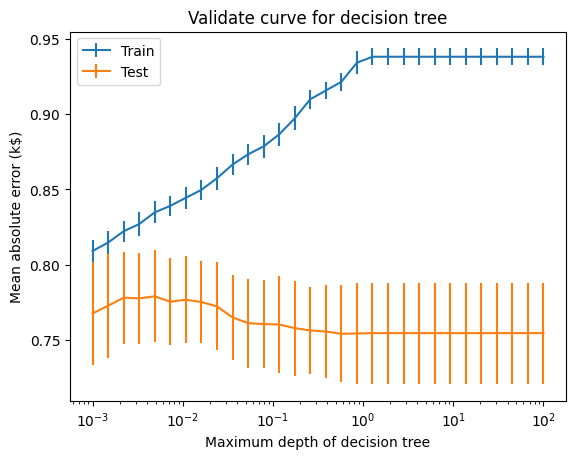

In [32]:
gamma_range = np.logspace(-3, 2, num=30)

disp = ValidationCurveDisplay.from_estimator(
                sv_class,
                features_df,
                target,
                param_name='gamma',
                param_range=gamma_range,
                cv=cv_mode,
                std_display_style='errorbar',
                            )

_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)

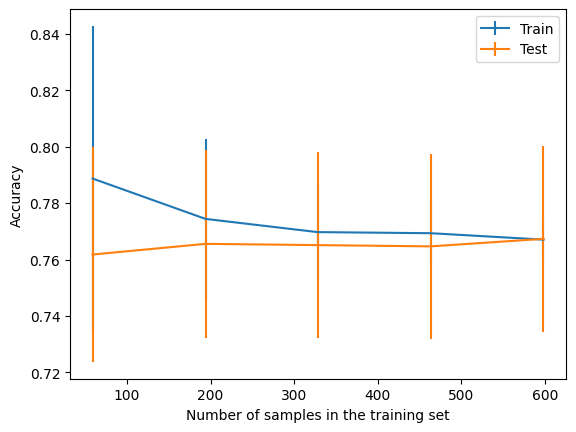

In [33]:

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

disp = LearningCurveDisplay.from_estimator(
                sv_class,
                features_df,
                target,
                train_sizes=train_sizes, 
                cv=cv_mode,
                score_type='both', #Training and testing
                score_name='Accuracy', 
                std_display_style='errorbar',
                n_jobs=2
                            )



In [43]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# instantiate the classifier
dum_class = DummyClassifier(strategy='most_frequent')


# Overfitting vs Under-fitting
cv_mode = ShuffleSplit(n_splits=30, test_size=0.2, random_state=123)

cv_results = cross_validate(
                    dum_class,
                    features_df,
                    target,
                    cv=cv_mode,
                    scoring='balanced_accuracy' #balanced scoring metric
                          )

# Vonvert CV to DF
cv_results = pd.DataFrame(cv_results)


# Preview the results
cv_results['test_score'].mean()

0.5

In [58]:
from sklearn.neighbors import KNeighborsClassifier


# Write Your Transformers
num_transformer = Pipeline(
                        # Standardize the numerical features
                       steps=('num_std', StandardScaler())
                         )



pre_proc = ColumnTransformer(
                                [
                    # Standardize the numerical features
                    ('num', num_transformer, features_df.columns)
                                ]
                            )

# Initialize the classifier
knn_class = KNeighborsClassifier(n_neighbors=1)



# Overfitting vs Under-fitting
cv_mode = ShuffleSplit(n_splits=30, test_size=0.2, random_state=123)

cv_results = cross_validate(
                    knn_class,
                    features_df,
                    target,
                    cv=cv_mode,
                    return_estimator=True,
                    return_train_score=True,
                    scoring='balanced_accuracy'
                          )

# Grabing the model parameters
# cv_results['estimator'][0].get_params()


# Convert CV to DF
cv_results = pd.DataFrame(cv_results)


# Preview the results
cv_results.head()

,fit_time,score_time,estimator,test_score,train_score
0,0.004047,0.010169,KNeighborsClassifier(n_neighbors=1),0.575000,0.891667
1,0.003158,0.008629,KNeighborsClassifier(n_neighbors=1),0.642744,0.883516
2,0.004749,0.009561,KNeighborsClassifier(n_neighbors=1),0.575968,0.895055
3,0.003690,0.010099,KNeighborsClassifier(n_neighbors=1),0.557866,0.892110
4,0.002000,0.008870,KNeighborsClassifier(n_neighbors=1),0.569242,0.872565


In [57]:
print(
      f'The train score is ---> {cv_results["train_score"].mean()}\n'
      f'The test score is ---> {cv_results["test_score"].mean()}'
     )

The train score is ---> 0.8841545484269323
The test score is ---> 0.5879811347320946


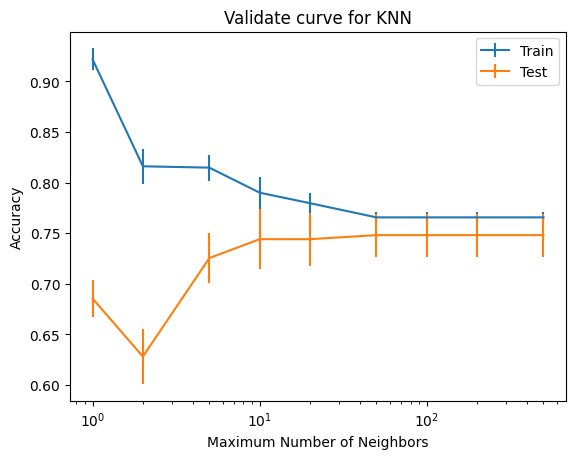

In [60]:
# Effect of n_neighbors on learning
param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])


cv_mode = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123,)

disp = ValidationCurveDisplay.from_estimator(
                knn_class,
                features_df,
                target,
                param_name='n_neighbors',
                param_range=param_range,
                cv=cv_mode,
                scoring='accuracy',
                std_display_style='errorbar',
                            )

_ = disp.ax_.set(
    xlabel="Maximum Number of Neighbors",
    ylabel="Accuracy",
    title="Validate curve for KNN",
)

> Underfitting happens when the gap between train and test scores is low and that both scores are low. When `n_neighbors` is high, underfitting occurs. The model lacks expressivity because it always considers the majority class of a large number of data points. Its prediction tends to be always the same, irrespective of the test point of interest.